In [9]:
# imports 
import pandas as pd
import numpy as np
import scipy.signal as ss
import scraper as sc
import indicators as ind
import analyze_patterns as ap
import datetime as dt
import matplotlib.pyplot as plt
import h5py 

***
# **Analyze Patterns**

This notebook aims for following goals:
1) Filter and detect critical reversal points in stock price development
2) Analyze stock behaviour before beginning of an uptrend in terms of technical analysis
    1) Determine how certain indicators behave (divergences, lower lows)
    2) Find patterns and determine their probability of success

Result of the analysis over the whole market should be the ability to find and backtest certain patterns and use these pattern to screen for trading opportunities

***
## **Load stock data**

Currently stock data are downloaded from the yahoo finanances directly. In the future I would prefer to download the data before hand (for multiple stocks) and run the evaluation on them 

In [10]:
# scrape for data
# currently only one stock, last 720 days, in the future update for 
stock = sc.stock_daily("CCL", save=False, delta=dt.timedelta(days=730))

***
## **Filter trends**

Detect trends in the price development and calculate linear regression between stationary points. Stationary points are detected using scipy function ```find_peaks()```, where sensitivity is set by prominence, which is calculated as an average width of the bollinger bands divided by the ```sensitivity``` function input. Typically, for decent precision, sensitivity 2 or 3 is enough. Output of the function is dataframe with following columns:

`p1` | `p2` | `val1` | `val2` | `length` | `uptrend` | `fit` | `std` | `risk_%` | `potential_%` | `ppd_%` |
----|----|----|----|----|----|----|----|----|----|----|
start index | end index | start close | end close | length of the trend | bool uptrend/downtrend | **a** in ax+b| std from linear fit | lowest/highest % from start in the opposite trend direction | whole trend profit | potential per day|

In [11]:
reg = ap.filter_trend(stock.data, sensitivity=4)

***
## Calculate patterns

First test will be with direction of typical price and volume for multiple timeframes: 5, 15, 25, 50 days

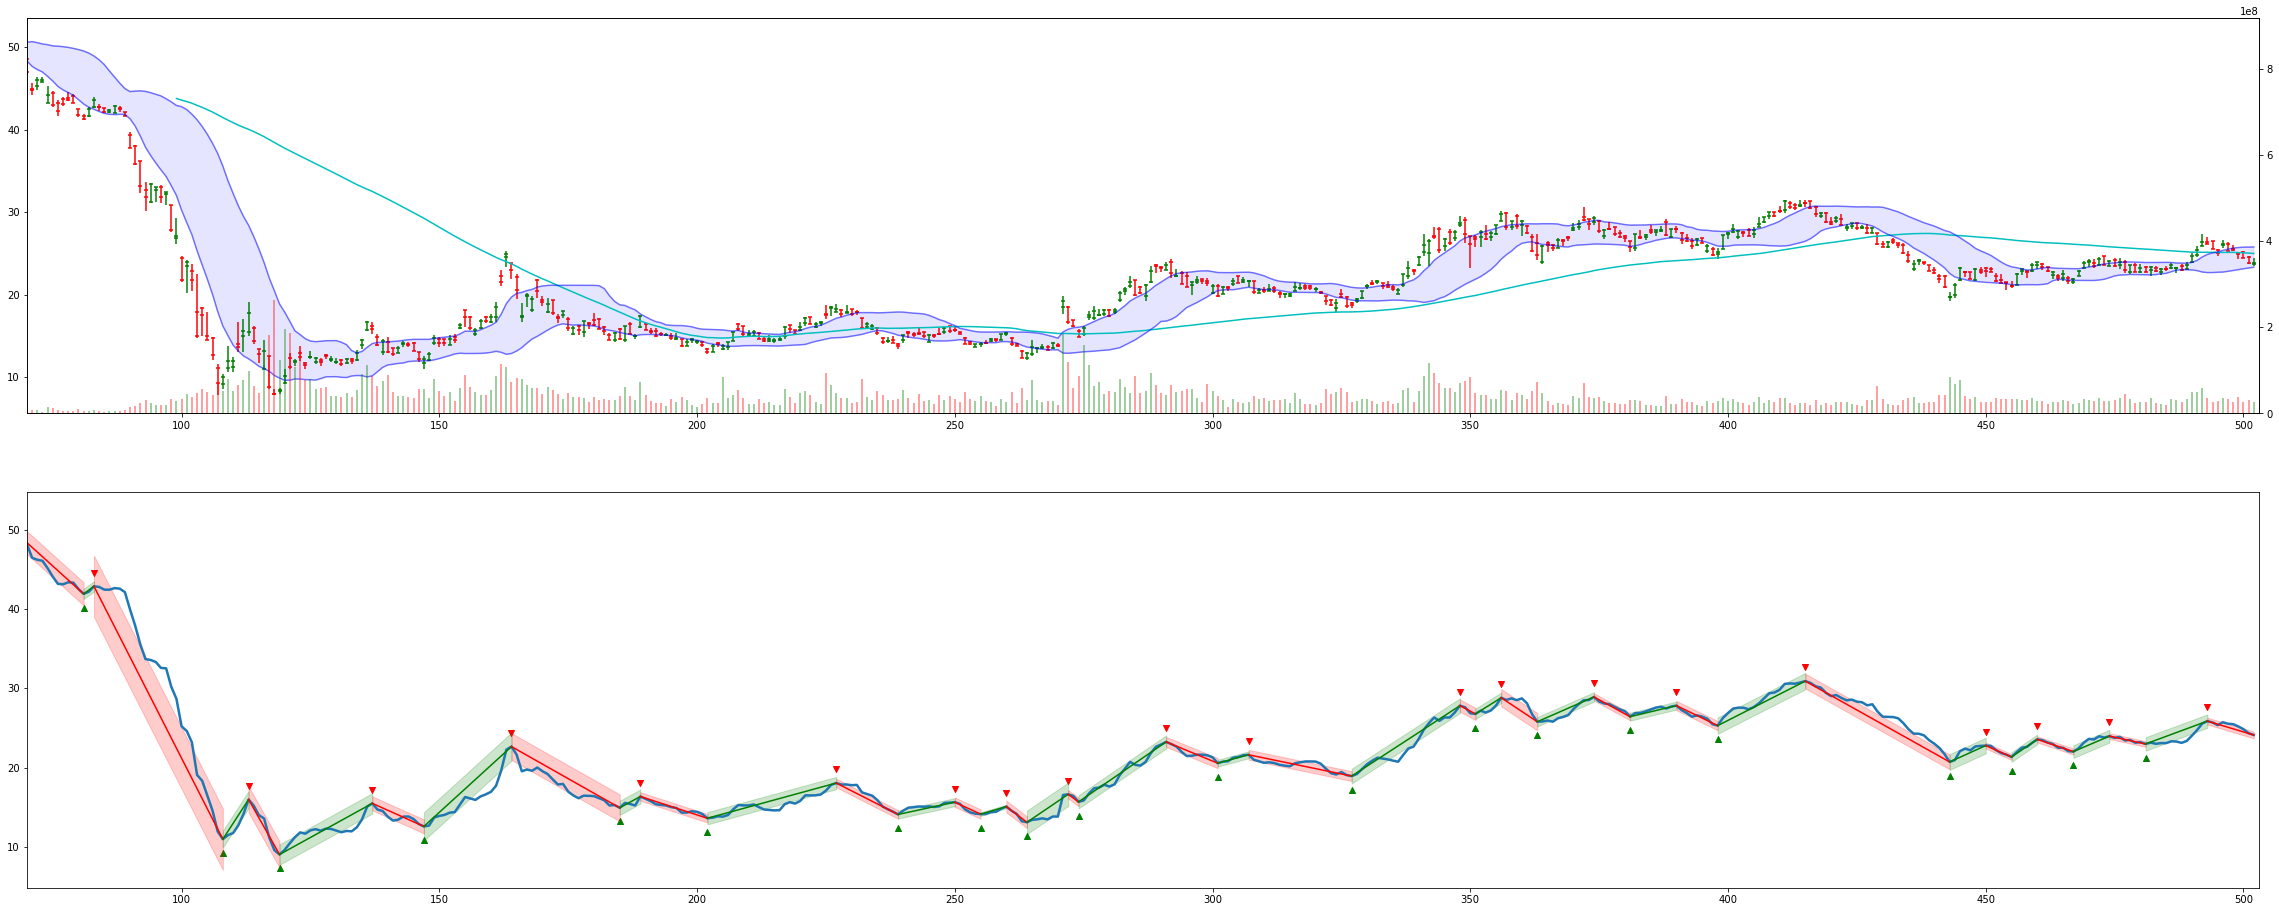

In [12]:
filtered_close = ind.ema(stock.data, 3, price="Close")["EMA"].to_numpy()
bollb = ind.bollbands(stock.data, stdn=1)

# create plot for the filtered data
fig, ax = plt.subplots(nrows=2, figsize=(40,16))

# plot candlesticks with bollbands and sma100
axy = ax[0].twinx()
ind.plot_candlestick(ax[0], axy, stock)
ax[0].plot(ind.sma(stock.data, 100, price="Close")["SMA"], color="c")
ax[0].plot(bollb["upper"], color="b", alpha=0.5)
ax[0].plot(bollb["lower"], color="b", alpha=0.5)
ax[0].fill_between(np.arange(bollb.shape[0]), bollb["lower"], bollb["upper"], color="b", alpha=0.1)
ax[0].set_xlim([70, stock.data.shape[0]])

# plot filtered data
ax[1].plot(filtered_close, linewidth=2.5)
ax[1].set_xlim([70, stock.data.shape[0]])
ax[1].scatter(reg[reg["uptrend"]==False]["p1"], filtered_close[reg[reg["uptrend"]==False]["p1"]]+(bollb["upper"] - bollb["lower"]).mean()/2, color="r", marker="v")
ax[1].scatter(reg[reg["uptrend"]==True]["p1"], filtered_close[reg[reg["uptrend"]==True]["p1"]]-(bollb["upper"] - bollb["lower"]).mean()/2, color="g", marker="^")
for i in reg.index:
    if reg.loc[i,"uptrend"] == True:
        ax[1].plot(np.arange(reg.loc[i,"p1"], reg.loc[i,"p2"]+1), reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"], color="g")
        ax[1].fill_between(np.arange(reg.loc[i,"p1"], reg.loc[i,"p2"]+1), reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"]+reg.loc[i, "std"], reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"]-reg.loc[i, "std"], color="g", alpha=0.2)
    else:
        ax[1].plot(np.arange(reg.loc[i,"p1"], reg.loc[i,"p2"]+1), reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"], color="r")
        ax[1].fill_between(np.arange(reg.loc[i,"p1"], reg.loc[i,"p2"]+1), reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"]+reg.loc[i, "std"], reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"]-reg.loc[i, "std"], color="r", alpha=0.2)

